1. Download the MNIST dataset and create a dataloader that adds gaussian noise to the input images.
2. Design and train an AutoEncoder on the MNIST dataset to denoise the noisy images.
3. Randomly choose one image for each digit and visualize the initial images and their corresponding noisy images and decoded images side by side.
4. Compute latent feature vectors of images. (The output of the encoder network)
5. Use PCA to reduce the dimensionality of latent features to 2 and visualize the data points in a scatter plot. Use a different color for each digit.
6. Repeat the previous step with TSNE.
7. What do you conclude from steps 4 and 5 about the learned latent representation of the data?

Bonus:
1. Create a data loader that rotates input images with a random degree.
2. Design and train a Variational AutoEncoder that gets rotated images as input and outputs an image so that the digit in the image would become horizontal.

Useful links:
- [AE](https://medium.com/@AnasBrital98/autoencoders-explained-da131e60e02a)
- [VAE](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)
- [PCA](https://towardsdatascience.com/the-most-gentle-introduction-to-principal-component-analysis-9ffae371e93b#:~:text=From%20Wikipedia%2C%20PCA%20is%20a,find%20unmeasured%20%E2%80%9Clatent%20variables%E2%80%9D.)
- [T-SNE](https://towardsdatascience.com/t-sne-clearly-explained-d84c537f53a)

Awnser : As you know CPA is a Linear fucntion and actualy can not model the nonlinear functions so we use T-SNE which use poolmax or something like that to use nonlinear functions to model the subject

Mohamadreza Pirpiran
99101319

In [45]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torch import nn
import plotly.express as px
from tqdm import tqdm
from PIL import Image


In [2]:
data_dir = 'data'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_transform = transforms.Compose([
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

train_size = len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(train_size - train_size * 0.2), int(train_size * 0.2)])
batch_size = 256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

123.19012296624732


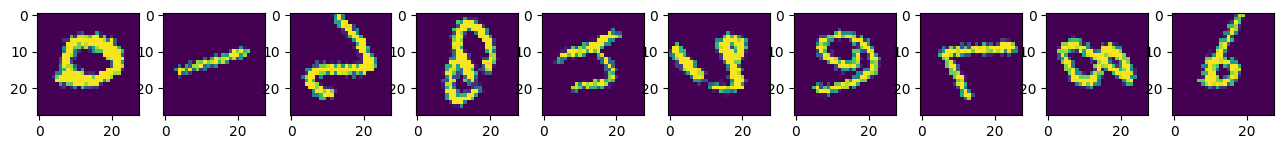

In [48]:
class Rotate(object):
    
    def __init__(self):
        self.degree = random.random() * 360 
        print(self.degree)
        pass
    

    
  
    def __call__(self, x):
        x = transforms.functional.rotate(img = x,angle = self.degree)
        return x
    
rotate_transform = transforms.Compose([
    transforms.ToTensor(),
    Rotate()
])

plt.figure(figsize=(16, 4.5))
targets = test_dataset.targets.numpy()
t_idx = {i: np.where(targets == i)[0][0] for i in range(10)}
for i in range(10):
    ax = plt.subplot(3, 10, i + 1)  
    img = test_dataset[t_idx[i]][0]
    img = rotate_transform(img)
    
    plt.imshow(img.permute(1, 2, 0))

In [3]:
class Encoder(nn.Module):

    def __init__(self, encoded_space_dim, fc2_input_dim):
        super().__init__()

        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )

        self.flatten = nn.Flatten(start_dim=1)

        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )

    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x


class Decoder(nn.Module):

    def __init__(self, encoded_space_dim, fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1,
                                      unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3,
                               stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2,
                               padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2,
                               padding=1, output_padding=1)
        )

    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x


loss_fn = torch.nn.MSELoss()

dim = 4
torch.manual_seed(0)

encoder = Encoder(encoded_space_dim=dim, fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=dim, fc2_input_dim=128)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

learning_rate = 0.001
optim = torch.optim.Adam(params_to_optimize, lr=learning_rate, weight_decay=1e-05)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

encoder.to(device)
decoder.to(device)


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [4]:
def add_noise(inputs, noise_factor=0.3):
    noisy = inputs + torch.randn_like(inputs) * noise_factor
    noisy = torch.clip(noisy, 0., 1.)
    return noisy

In [6]:
def train_epoch_den(encoder, decoder, device, dataloader, loss_fn, optimizer, noise_factor=0.3):
    encoder.train()
    decoder.train()
    train_loss = []
    for image_batch, _ in dataloader:
        image_noisy = add_noise(image_batch, noise_factor)
        image_batch = image_batch.to(device)
        image_noisy = image_noisy.to(device)
        encoded_data = encoder(image_noisy)
        decoded_data = decoder(encoded_data)
        loss = loss_fn(decoded_data, image_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)


def test_epoch_den(encoder, decoder, device, dataloader, loss_fn, noise_factor=0.3):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            image_noisy = add_noise(image_batch, noise_factor)
            image_noisy = image_noisy.to(device)
            encoded_data = encoder(image_noisy)
            decoded_data = decoder(encoded_data)
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label)
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data


In [7]:
def plot_ae_outputs_den(encoder, decoder, ith_itr,n=10, noise_factor=0.3):
    plt.figure(figsize=(16, 4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i: np.where(targets == i)[0][0] for i in range(n)}
    plt.title(label= f'${ith_itr} Result of Training')
    for i in range(n):

        ax = plt.subplot(3, n, i + 1)
        img = test_dataset[t_idx[i]][0].unsqueeze(0)
        image_noisy = add_noise(img, noise_factor)
        image_noisy = image_noisy.to(device)

        encoder.eval()
        decoder.eval()

        with torch.no_grad():
            rec_img = decoder(encoder(image_noisy))

        plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n // 2:
            ax.set_title('Original images')
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(image_noisy.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n // 2:
            ax.set_title('Corrupted images')

        ax = plt.subplot(3, n, i + 1 + n + n)
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n // 2:
            ax.set_title('Reconstructed images')
    plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.7,
                        top=0.9,
                        wspace=0.3,
                        hspace=0.3)
    plt.show()

0


[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


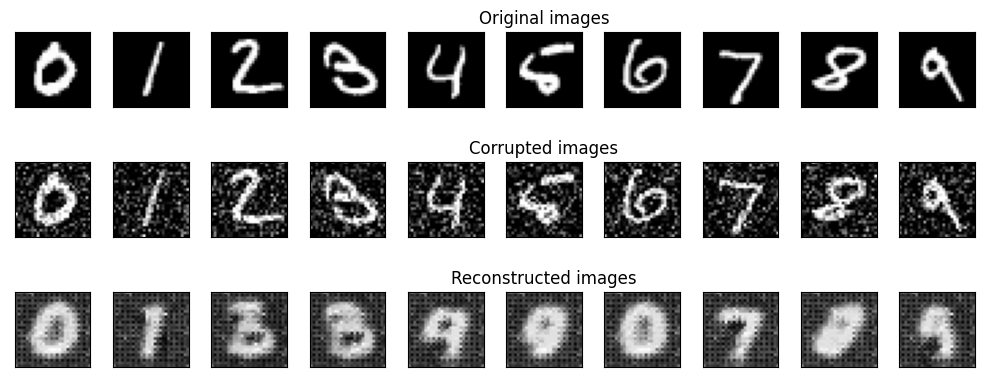

1
2
3
4
5


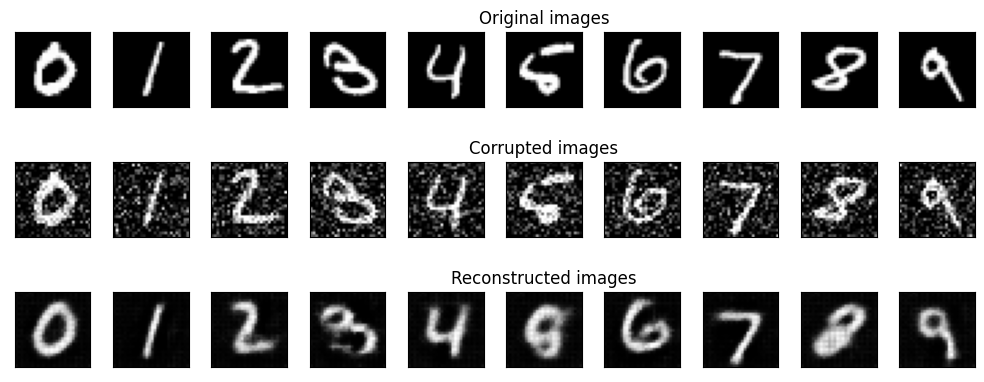

6
7
8
9
10


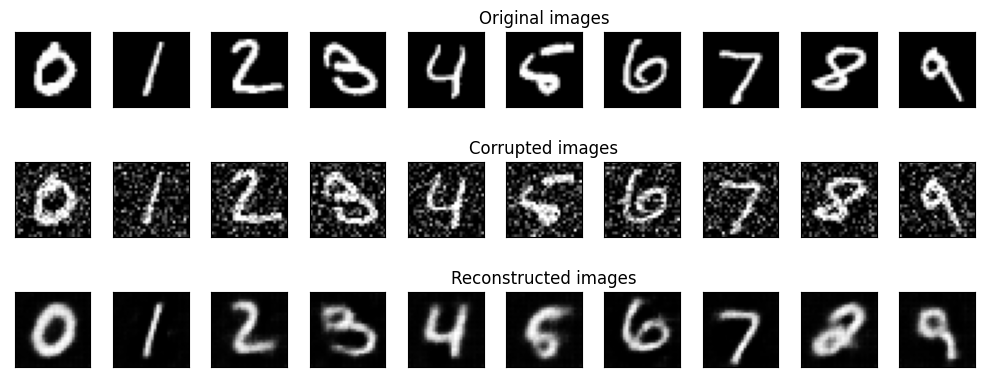

11
12
13
14
15


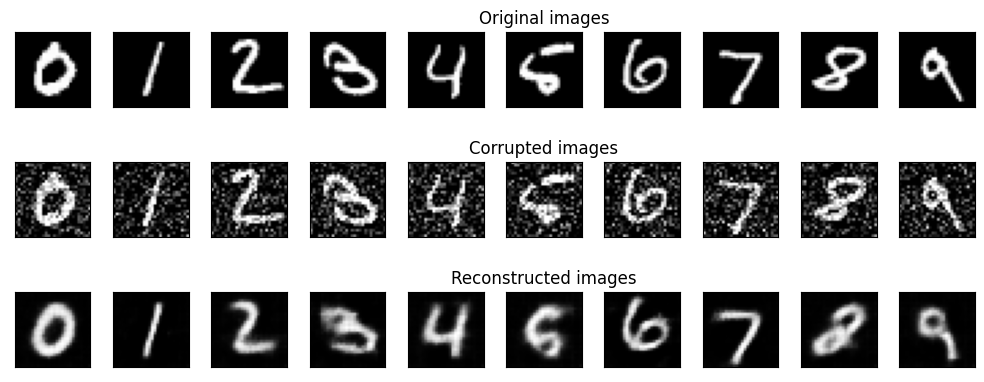

16
17
18
19
20


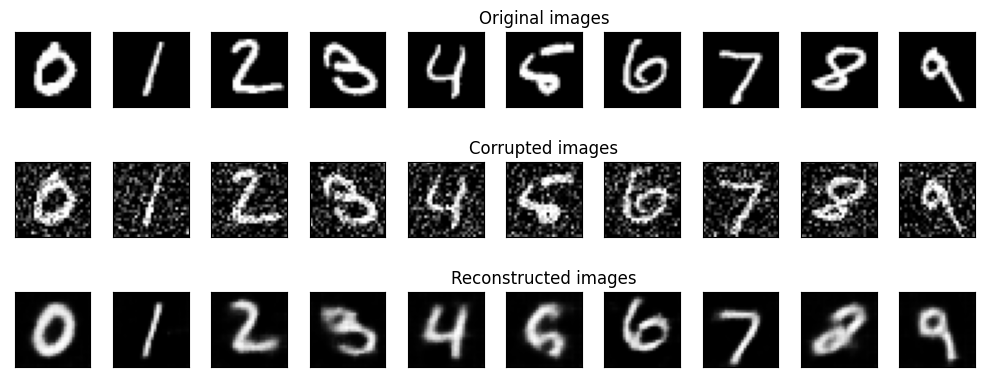

21
22
23
24
25


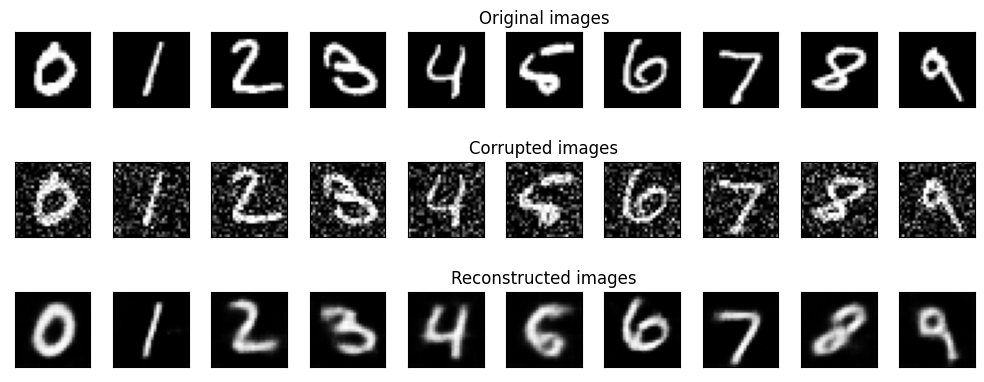

26
27
28
29


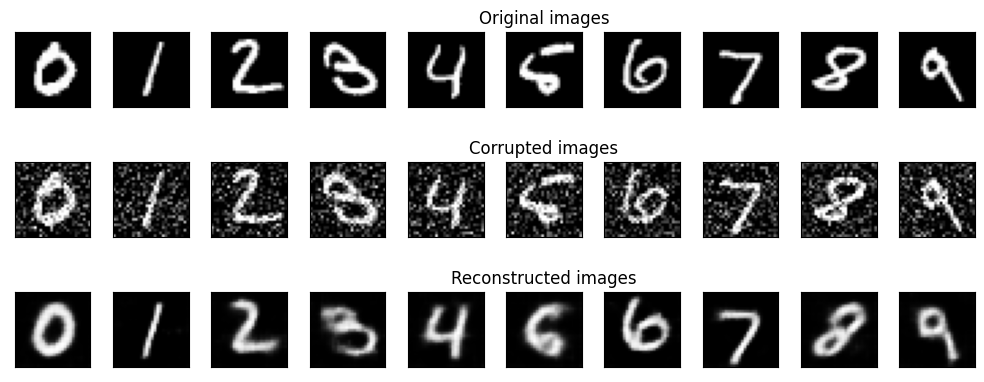

In [9]:
noise_factor = 0.3
num_epochs = 30
history_da = {'train_loss': [], 'val_loss': []}

for epoch in range(num_epochs):
    train_loss = train_epoch_den(
        encoder=encoder,
        decoder=decoder,
        device=device,
        dataloader=train_loader,
        loss_fn=loss_fn,
        optimizer=optim, noise_factor=noise_factor)
    val_loss = test_epoch_den(
        encoder=encoder,
        decoder=decoder,
        device=device,
        dataloader=valid_loader,
        loss_fn=loss_fn, noise_factor=noise_factor)
    print(epoch)

    history_da['train_loss'].append(train_loss)
    history_da['val_loss'].append(val_loss)
    if epoch % 5 == 0 or epoch == 29:
        plot_ae_outputs_den(encoder, decoder, noise_factor=noise_factor,ith_itr=epoch)

In [10]:
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    encoder.eval()
    with torch.no_grad():
        encoded_img = encoder(img)
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
encoded_samples = pd.DataFrame(encoded_samples)

px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1',
           color=encoded_samples.label.astype(str), opacity=0.7)

100%|██████████| 10000/10000 [00:02<00:00, 3466.61it/s]
